# Clean-Label Feature Collision Attacks on a Keras Classifier

In [1]:
# import torch
# a = torch.empty(5, 7, dtype=torch.float)
# print(id(a))
# print(a)

In [2]:
# import numpy as np
# b = torch.tensor(np.random.rand(5,7))
# print(b)
# print(id(b))
# a.data.copy_(b.data)
# print(id(a))
# print(a)

In [3]:
pwd

'/home/shritipriya/adversarial-robustness-toolbox/notebooks'

In this notebook, we will learn how to use ART to run a clean-label feature collision poisoning attack on a neural network trained with Keras. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/1804.00792) by Shafahi, Huang, et. al. 2018.

In [4]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Transpose the axes to make input of acceptable format by PyTorchClassifier
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)

shape of x_train (1000, 32, 32, 3)
shape of y_train (1000, 10)


## Load Model to be Attacked

In this example, we using a RESNET50 model pretrained on the CIFAR dataset.

In [6]:
import torch.optim as optim
classifier_model = torch.load('ciafr10_alexnet_pytorch_linear.pt')
# for param in classifier_model.parameters():
#     param.requires_grad = False
classifier_model.eval()
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             preprocessing=(0.5,1),nb_classes=10,input_shape=(32,32,3),loss=criterion,
                             optimizer=optimizer)


In [7]:
classifier_model

Model(
  (_Model__vars): ParameterDict(
      (t_classifier_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x10 (GPU 0)]
      (t_classifier_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 0)]
      (t_scale): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_bias): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_mean): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_var): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_33_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
      (t_conv2d_33_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_31_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
      (t_conv2d_31_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_29_3_kernel_0):

## Choose Target Image from Test Set

shape of target_instance (32, 32, 3)
shape of img_plot (32, 32, 3)
shape of target_instance (1, 32, 32, 3)
true_class: bird
predicted_class: bird
n_n_linear_1


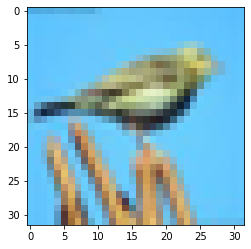

In [8]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)
print("shape of target_instance",target_instance[0].shape)
img_plot = target_instance[0]
print("shape of img_plot",img_plot.shape)
fig = plt.imshow(img_plot)
print("shape of target_instance",target_instance.shape)
print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

feature_layer = classifier.layer_names[-1]
print(feature_layer)

In [9]:
classifier.layer_names

['_Model__vars',
 'n_n_conv2d_1',
 'n_n_conv2d_2',
 'n_n_conv2d_3',
 'n_n_batch_normalization_3',
 'n_n_conv2d_4',
 'n_n_conv2d_5',
 'n_n_batch_normalization_5',
 'n_n_conv2d_6',
 'n_n_conv2d_7',
 'n_n_batch_normalization_7',
 'n_n_conv2d_8',
 'n_n_conv2d_9',
 'n_n_batch_normalization_9',
 'n_n_conv2d_10',
 'n_n_conv2d_11',
 'n_n_conv2d_14',
 'n_n_batch_normalization_11',
 'n_n_conv2d_12',
 'n_n_conv2d_13',
 'n_n_batch_normalization_13',
 'n_n_conv2d_15',
 'n_n_conv2d_16',
 'n_n_batch_normalization_15',
 'n_n_conv2d_17',
 'n_n_conv2d_18',
 'n_n_batch_normalization_17',
 'n_n_conv2d_19',
 'n_n_conv2d_20',
 'n_n_batch_normalization_19',
 'n_n_conv2d_21',
 'n_n_conv2d_22',
 'n_n_conv2d_25',
 'n_n_batch_normalization_21',
 'n_n_conv2d_23',
 'n_n_conv2d_24',
 'n_n_batch_normalization_23',
 'n_n_conv2d_26',
 'n_n_conv2d_27',
 'n_n_batch_normalization_25',
 'n_n_conv2d_28',
 'n_n_conv2d_29',
 'n_n_batch_normalization_27',
 'n_n_conv2d_30',
 'n_n_conv2d_31',
 'n_n_batch_normalization_29',
 'n_

In [10]:
# import torchviz

# target_instance = torch.from_numpy(target_instance).cuda()
# y = classifier_model(target_instance)
# print(y)
# torchviz.dot.make_dot(y.mean(), params=dict(classifier_model.named_parameters()))

In [11]:
# pip install graphviz


# Calculate Accuracy of Model

In [12]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
print("Benign accuracy of the model: {}".format(100*(nb_correct_pred/1000)))

Benign accuracy of the model: 90.60000000000001


## Poison Training Images to Misclassify Test

The attacker wants to make it such that whenever a prediction is made on this particular cat the output will be a horse.

In [13]:
base_class = "frog" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
print("shape of base_instances",base_instances.shape)
print("shape of base_labels",base_labels.shape)
x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

shape of base_instances (10, 32, 32, 3)
shape of base_labels (10, 10)
New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


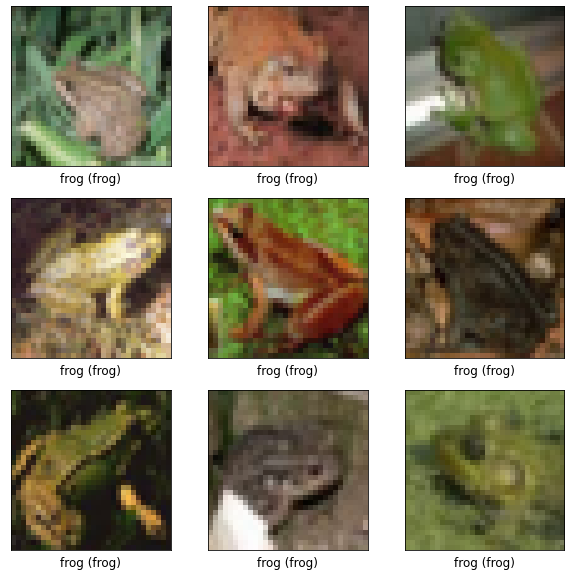

In [14]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

The captions on the images can be read: `predicted label (true label)`

# Computation Graph Visualization

## Creating Poison Frogs

In [15]:
np.expand_dims(base_instances[0],axis=0).shape

(1, 32, 32, 3)

In [16]:
# Keep this fixed
# max_iter = 10
attack = FeatureCollisionAttack(classifier, 
                                target_instance, 
                                feature_layer, 
                                max_iter=10, 
                                similarity_coeff=256,
                                watermark=0.3)
#poison, poison_labels = attack.poison(np.expand_dims(base_instances[0],axis=0))
poison, poison_labels = attack.poison(base_instances)

target max 1.0
target min 0.050980393
target_features max 6.4562984
target_features min -8.706204
poison_features max 20.318945
poison_features min -10.06916
2nd time poison_features max 20.318945
2nd time poison_features min -10.06916
Learning rate: 0.01


Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(37.9862, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -41.849243 31.938038
self.attack_loss MSELoss()
True
False
True
False
tensor(17.6592, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -9.4341755 9.055974
self.attack_loss MSELoss()
True
False
True
False
tensor(5.1223, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.5749173 4.035108
self.attack_loss MSELoss()
True
False
True
False
tensor(4.6654, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.850395 4.682682
self.attack_loss MSELoss()
True
False
True
False
tensor(4.1011, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.2372518 6.2298503
self.attack_loss MSELoss()
True
False
True
False
tensor(6.8602, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.9300394 6.0194864
self.attack_loss MSELoss()
True
False
True
False
tensor(5.0566, device='cuda:0

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(89.9416, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -92.31662 76.305016
self.attack_loss MSELoss()
True
False
True
False
tensor(35.3994, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -22.593391 26.721918
self.attack_loss MSELoss()
True
False
True
False
tensor(7.7377, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.9869018 10.735796
self.attack_loss MSELoss()
True
False
True
False
tensor(34.1609, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -12.332623 9.374143
self.attack_loss MSELoss()
True
False
True
False
tensor(16.4185, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.088027 9.076571
self.attack_loss MSELoss()
True
False
True
False
tensor(5.8562, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.000698 5.2094545
self.attack_loss MSELoss()
True
False
True
False
tensor(1.7525, device='cuda:

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(44.2502, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -48.82251 47.413734
self.attack_loss MSELoss()
True
False
True
False
tensor(56.7971, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -27.076612 22.168491
self.attack_loss MSELoss()
True
False
True
False
tensor(20.5304, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -16.792124 17.68275
self.attack_loss MSELoss()
True
False
True
False
tensor(9.7390, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.021428 6.6240873
self.attack_loss MSELoss()
True
False
True
False
tensor(1.5563, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -2.5249333 2.1316311
self.attack_loss MSELoss()
True
False
True
False
tensor(0.4678, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -0.90013516 1.1328324
self.attack_loss MSELoss()
True
False
True
False
tensor(0.1935, device='cud

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(79.4814, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -79.974106 46.758102
self.attack_loss MSELoss()
True
False
True
False
tensor(34.6916, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -29.551014 22.05755
self.attack_loss MSELoss()
True
False
True
False
tensor(19.4846, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -12.682041 16.294397
self.attack_loss MSELoss()
True
False
True
False
tensor(4.5057, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.3067126 6.073195
self.attack_loss MSELoss()
True
False
True
False
tensor(1.1458, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -1.8939948 2.2462676
self.attack_loss MSELoss()
True
False
True
False
tensor(0.0940, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -0.65674055 0.6180431
self.attack_loss MSELoss()
True
False
True
False
tensor(0.0495, device='cu

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(87.0676, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -53.910015 39.10796
self.attack_loss MSELoss()
True
False
True
False
tensor(24.6125, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -13.915182 14.238286
self.attack_loss MSELoss()
True
False
True
False
tensor(5.6591, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.2942457 7.079455
self.attack_loss MSELoss()
True
False
True
False
tensor(3.4247, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.347777 5.928906
self.attack_loss MSELoss()
True
False
True
False
tensor(3.6865, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.3809943 7.610567
self.attack_loss MSELoss()
True
False
True
False
tensor(2.3162, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.4145336 3.467852
self.attack_loss MSELoss()
True
False
True
False
tensor(0.7720, device='cuda:0',

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(73.0110, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -64.06148 91.38228
self.attack_loss MSELoss()
True
False
True
False
tensor(33.5078, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -20.468819 19.995438
self.attack_loss MSELoss()
True
False
True
False
tensor(14.3141, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.259899 12.080298
self.attack_loss MSELoss()
True
False
True
False
tensor(5.9880, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.106854 11.416259
self.attack_loss MSELoss()
True
False
True
False
tensor(2.5961, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.511469 5.3379674
self.attack_loss MSELoss()
True
False
True
False
tensor(2.3217, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.522221 6.910127
self.attack_loss MSELoss()
True
False
True
False
tensor(3.0124, device='cuda:0'

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(41.7717, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -68.346085 41.492393
self.attack_loss MSELoss()
True
False
True
False
tensor(20.8774, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -24.708818 22.250498
self.attack_loss MSELoss()
True
False
True
False
tensor(8.1752, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.488885 7.8216467
self.attack_loss MSELoss()
True
False
True
False
tensor(8.2414, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -11.56721 10.170261
self.attack_loss MSELoss()
True
False
True
False
tensor(6.5501, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.066887 6.0396514
self.attack_loss MSELoss()
True
False
True
False
tensor(1.7068, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.0672393 4.9368515
self.attack_loss MSELoss()
True
False
True
False
tensor(3.4917, device='cuda

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(58.5765, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -38.846542 63.569508
self.attack_loss MSELoss()
True
False
True
False
tensor(39.9087, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -19.725712 18.487713
self.attack_loss MSELoss()
True
False
True
False
tensor(15.3068, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -14.108639 10.829589
self.attack_loss MSELoss()
True
False
True
False
tensor(4.7650, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.00646 11.676435
self.attack_loss MSELoss()
True
False
True
False
tensor(9.8103, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.992641 11.870391
self.attack_loss MSELoss()
True
False
True
False
tensor(9.0314, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -9.690192 8.705097
self.attack_loss MSELoss()
True
False
True
False
tensor(8.1254, device='cuda:

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(33.5461, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -35.110435 22.438517
self.attack_loss MSELoss()
True
False
True
False
tensor(14.4779, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -17.337402 14.22053
self.attack_loss MSELoss()
True
False
True
False
tensor(3.2365, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.098844 7.2615194
self.attack_loss MSELoss()
True
False
True
False
tensor(9.3644, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.080738 10.548616
self.attack_loss MSELoss()
True
False
True
False
tensor(5.9790, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -12.762691 10.006845
self.attack_loss MSELoss()
True
False
True
False
tensor(4.3993, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.7508454 7.2878184
self.attack_loss MSELoss()
True
False
True
False
tensor(0.7509, device='cud

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(91.7781, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -138.24348 173.43701
self.attack_loss MSELoss()
True
False
True
False
tensor(38.7958, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -15.276663 15.888664
self.attack_loss MSELoss()
True
False
True
False
tensor(4.8185, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.280832 6.6657343
self.attack_loss MSELoss()
True
False
True
False
tensor(4.4012, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.5328526 6.0862136
self.attack_loss MSELoss()
True
False
True
False
tensor(7.5612, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.7908397 11.621291
self.attack_loss MSELoss()
True
False
True
False
tensor(6.9738, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -9.976386 7.3982935
self.attack_loss MSELoss()
True
False
True
False
tensor(3.4431, device='cuda

In [17]:
poison

array([[[[0.3504834 , 0.41268176, 0.45198494],
         [0.36569428, 0.45548815, 0.4838267 ],
         [0.28781497, 0.43104136, 0.4057641 ],
         ...,
         [0.3377877 , 0.5828038 , 0.50029874],
         [0.29289576, 0.503124  , 0.49267596],
         [0.35931283, 0.55475956, 0.55337536]],

        [[0.40751782, 0.55112964, 0.54882896],
         [0.40400702, 0.6425004 , 0.62730324],
         [0.36249605, 0.6008983 , 0.5342045 ],
         ...,
         [0.32087302, 0.50420845, 0.47966352],
         [0.36699295, 0.54890156, 0.5612862 ],
         [0.36658424, 0.5487893 , 0.56855595]],

        [[0.370805  , 0.6009831 , 0.58755624],
         [0.3741764 , 0.6947547 , 0.674265  ],
         [0.35669297, 0.65972805, 0.6093205 ],
         ...,
         [0.40070033, 0.56396997, 0.55736804],
         [0.4482019 , 0.58730227, 0.5897864 ],
         [0.3121895 , 0.44106248, 0.49800396]],

        ...,

        [[0.5237261 , 0.7176239 , 0.66090953],
         [0.56194746, 0.68622226, 0.6558261 ]

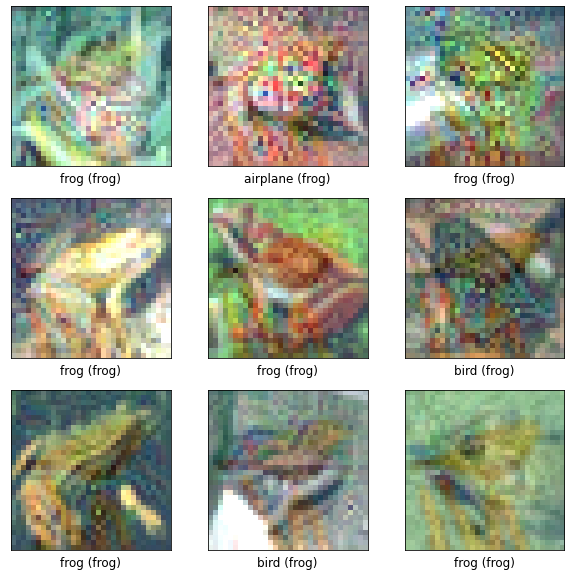

In [18]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(poison_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')


Notice how the network classifies most of theses poison examples as frogs, and it's not incorrect to do so. The examples look mostly froggy. A slight watermark of the target instance is also added to push the poisons closer to the target class in feature space.

## Training with Poison Images

In [19]:
import torch.optim as optim
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, poison_labels])
classifier_model.train()
classifier.fit(adv_train, adv_labels, nb_epochs=25, batch_size=4)

## Fooled Network Misclassifies Bird

true_class: bird
predicted_class: frog


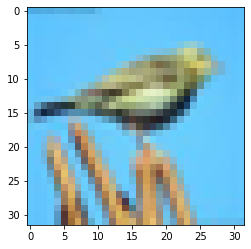

In [20]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [21]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
print("Benign accuracy of the model: {}".format(100*(nb_correct_pred/1000)))

Benign accuracy of the model: 53.900000000000006
